In [1]:
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from mpl_toolkits import mplot3d
from klepto.archives import dir_archive
import cv2
import time
from scipy.io import savemat

In [2]:
BEDFORMS = ['corals', 'canopy', 'rocks', 'dunes']
flow_speeds = ['fast', 'med', 'slow']
submergences = ['Deep', 'Intermed', 'Shallow']
colors = {'corals':'dodgerblue','canopy':'green', 'rocks':'orange', 'dunes':'brown'}

In [3]:
bed_idx = 0
flow_idx = 0
submergence_idx = 2
TEST = 4
BATCH_FRAMES =  75# for data acquired at 3 fp, total of 900, per subfolder 225 frames. 225/75 = 9

DIST = 247

# SET the data variables
FLOW_SPEED = flow_speeds[flow_idx]
SUBMERGENCE = submergences[submergence_idx]
BEDFORM = BEDFORMS[bed_idx]
print("{}_{}Flow_{}H_test{}".format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST))

corals_fastFlow_ShallowH_test4


## PSD using 2D FFT

In [4]:
for serial,i in enumerate([1,2,3,4]):#range(1,5):
    # choose the data
    SUBFOLDER = i

    # source data folders
#     data_foldername = "{}_{}Flow_{}H_test{}_subFolder{}".format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST, SUBFOLDER)
#     data_foldername = "{}_{}Flow_{}H_test{}_centeredCam_{}cmDownstreamUpperROI_flume_LookAngle_35Deg_subFolder{}".format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST,DIST, SUBFOLDER)
    data_foldername ="waterjet_powerHigh_Dist15cmBoilHeadtoROITop_15fps_25Pump_24cmH_industrialHose_subFolder{}".format(SUBFOLDER)
    print(data_foldername)
    data_location =  '../TOSHIBA_Drive/saksham_polar_cam_FLIR'
    save_location =  "../FLIR_Camera"
    klepto_saved_data_origin = 'klepto_bulk_data_saves' 

    # retrive the saved data
    data_origin = os.path.join(data_location, klepto_saved_data_origin, data_foldername)
    bed_data ={BEDFORM:{}}
    tic = time.time()
    assert os.path.exists(data_origin) == True
    data = dir_archive(data_origin, {}, serialized=True, cached=False)
    _, bed_data[BEDFORM]['all_slopeAzi_maps']\
                = cv2.cartToPolar(data['all_sy_maps'], data['all_sx_maps'], angleInDegrees=True)
    bed_data[BEDFORM]['all_sx_maps'] = data['all_sx_maps']
    bed_data[BEDFORM]['all_sy_maps'] = data['all_sy_maps']
    
    del data
    toc = time.time()
    print("time taken to load the data  = ", toc-tic)

    NUM_FRAMES = bed_data[BEDFORM]['all_slopeAzi_maps'].shape[-1]
    print("NUM_FRAMES is {} and datatype is {}".format(NUM_FRAMES,type(bed_data[BEDFORM]['all_slopeAzi_maps'])))

    # Accumulate the mean PSD of every BATCH_SIZE frames 
    if serial==0:
        slopeAzi_hat_mean = []
        slopeAzi_hat_mag_mean = []

    for i in range(NUM_FRAMES//BATCH_FRAMES):    

        slopeAzi_hat = np.fft.fft2(bed_data[BEDFORM]['all_slopeAzi_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], axes = ([0,1]))
        slopeAzi_hat = np.fft.fftshift(slopeAzi_hat) # DC content at the center
        slopeAzi_hat_mag = (np.log(np.abs(slopeAzi_hat)))**2
        
        slopeAzi_hat_mean.append(np.mean(slopeAzi_hat, axis = (2)))
        slopeAzi_hat_mag_mean.append(np.mean(slopeAzi_hat_mag, axis = (2)))
    
    del bed_data,  slopeAzi_hat, slopeAzi_hat_mag

waterjet_powerHigh_Dist15cmBoilHeadtoROITop_15fps_25Pump_24cmH_industrialHose_subFolder1
time taken to load the data  =  83.74174475669861
NUM_FRAMES is 225 and datatype is <class 'numpy.ndarray'>
waterjet_powerHigh_Dist15cmBoilHeadtoROITop_15fps_25Pump_24cmH_industrialHose_subFolder2
time taken to load the data  =  84.33762073516846
NUM_FRAMES is 225 and datatype is <class 'numpy.ndarray'>
waterjet_powerHigh_Dist15cmBoilHeadtoROITop_15fps_25Pump_24cmH_industrialHose_subFolder3
time taken to load the data  =  86.4504942893982
NUM_FRAMES is 225 and datatype is <class 'numpy.ndarray'>
waterjet_powerHigh_Dist15cmBoilHeadtoROITop_15fps_25Pump_24cmH_industrialHose_subFolder4
time taken to load the data  =  88.8372094631195
NUM_FRAMES is 225 and datatype is <class 'numpy.ndarray'>


In [5]:
FreqCompRows = np.fft.fftfreq(slopeAzi_hat_mean[0].shape[0],d=1)
FreqCompCols = np.fft.fftfreq(slopeAzi_hat_mean[0].shape[1],d=1)
FreqCompRows = np.fft.fftshift(FreqCompRows)
FreqCompCols = np.fft.fftshift(FreqCompCols)

R,C = np.meshgrid(FreqCompRows, FreqCompCols)
M,N = slopeAzi_hat_mean[0].shape[0:2]

In [6]:
mean  = slopeAzi_hat_mean[0]
mag_mean = slopeAzi_hat_mag_mean[0]
instances = len(slopeAzi_hat_mean)
print("number of frames to average: ", instances)
for i in range(1,instances):
    mean += slopeAzi_hat_mean[i]
    mag_mean += slopeAzi_hat_mag_mean[i]
mean /= instances
mag_mean /= instances

number of frames to average:  12


In [7]:
mean.shape
mag_mean.shape

(1024, 1224)

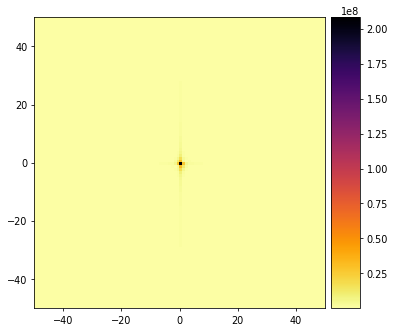

In [8]:
lim = 100

w = 6
h = 6
d = 70
ax0 = plt.figure(figsize=(w, h), dpi=d).gca()
im0 = ax0.imshow(np.abs(mean)[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2] , \
                 cmap = plt.cm.inferno_r, aspect='auto'\
                ,extent=(-lim// 2, lim// 2, -lim // 2, lim // 2))#, vmin = 0, vmax = 255)
divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes("right", size="10%", pad=0.08)
cbar0 = plt.colorbar(im0, cax=cax0)
ax0.set_aspect('equal')

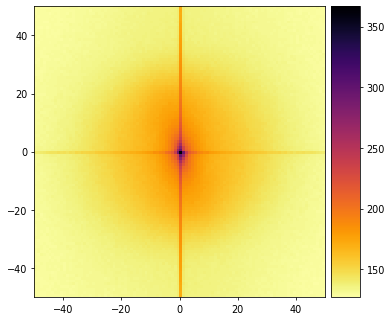

In [9]:
lim = 100

w = 6
h = 6
d = 70
ax0 = plt.figure(figsize=(w, h), dpi=d).gca()
im0 = ax0.imshow(mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2] , \
                 cmap = plt.cm.inferno_r, aspect='auto'\
                ,extent=(-lim// 2, lim// 2, -lim // 2, lim // 2))#, vmin = 0, vmax = 255)
divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes("right", size="10%", pad=0.08)
cbar0 = plt.colorbar(im0, cax=cax0)
ax0.set_aspect('equal')

## Save the 2D FFT data to visualize using Matlab

In [10]:
# dic = {"R":R,"C":C,\
#         "FreqCompRows":FreqCompRows, "FreqCompCols":FreqCompCols, \
#         "slopeAzi_hat_mean":mean,\
#         "slopeMag_hat_mag_mean": mag_mean,\
#         'BEDFORM':BEDFORM, 'FLOW_SPEED':FLOW_SPEED,'SUBMERGENCE':SUBMERGENCE}

dic = {"R":R,"C":C,\
        "FreqCompRows":FreqCompRows, "FreqCompCols":FreqCompCols, \
        "slopeAzi_hat_mean":mean,\
        "slopeMag_hat_mag_mean": mag_mean}
# filename = 'ZOOMED_mean_2DFFT_slopeAzi_{}_{}Flow_{}H_test{}.mat'.format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST)
filename = 'ZOOMED_mean_2DFFT_powerHigh_Dist15cm_15fps_25Pump_24cmH.mat'.format(BEDFORM, DIST)
save_dest = os.path.join(save_location, klepto_saved_data_origin, filename)
savemat(save_dest,dic)